# **Abordagem: Dataset completo**

## **Imports**

In [40]:
import kagglehub

import pandas as pd
import pandasql as ps
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, hour, date_format

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import (LogisticRegression, DecisionTreeClassifier, RandomForestClassifier,
                                       NaiveBayes, MultilayerPerceptronClassifier, LinearSVC)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

## **Carregando Dados**

In [2]:
spark = SparkSession.builder.appName('Traffic-Accidents').config("spark.driver.memory", "4g") \
                                                .config("spark.executor.memory", "4g") \
                                                .config("spark.executor.cores", "2") \
                                                .config("spark.num.executors", "10") \
                                                .getOrCreate()

25/01/26 15:08:07 WARN Utils: Your hostname, notebook resolves to a loopback address: 127.0.1.1; using 192.168.18.27 instead (on interface wlp2s0)
25/01/26 15:08:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/26 15:08:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Download latest version
# path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")
# print("Path to dataset files:", path)

df = spark.read.csv('/home/arthur/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13/US_Accidents_March23.csv', header=True, inferSchema=True)

df.show()

## **Descrição dos Dados**

In [5]:
print(f"Número de Linhas: {df.count()}")
print(f"Número de Colunas: {len(df.columns)}")

Número de Linhas: 7728394
Número de Colunas: 46


### Identificação e Origem
ID: Identificador único para cada registro no dataset.

Source: Fonte ou sistema de onde os dados foram obtidos.

### Detalhes do Incidente
Severity: Nível de gravidade do incidente, geralmente representado por um número inteiro.

Start_Time: Data e hora de início do incidente.

End_Time: Data e hora de término do incidente.

Description: Descrição textual do incidente.

### Localização Geográfica
Start_Lat: Latitude do ponto inicial do incidente.

Start_Lng: Longitude do ponto inicial do incidente.

End_Lat: Latitude do ponto final do incidente.

End_Lng: Longitude do ponto final do incidente.

Distance(mi): Distância total do incidente em milhas.

Street: Nome da rua onde o incidente ocorreu.

City: Cidade onde o incidente ocorreu.

County: Condado onde o incidente ocorreu.

State: Estado onde o incidente ocorreu.

Zipcode: Código postal da área onde o incidente ocorreu.

Country: País onde o incidente ocorreu.

Timezone: Fuso horário da localização do incidente.

Airport_Code: Código do aeroporto mais próximo ao local do incidente.


### Condições Climáticas
Weather_Timestamp: Data e hora da coleta das condições meteorológicas.

Temperature(F): Temperatura em graus Fahrenheit no momento do incidente.

Wind_Chill(F): Sensação térmica em graus Fahrenheit.

Humidity(%): Umidade relativa do ar em porcentagem.

Pressure(in): Pressão atmosférica em polegadas de mercúrio.

Visibility(mi): Visibilidade em milhas no momento do incidente.

Wind_Direction: Direção do vento.

Wind_Speed(mph): Velocidade do vento em milhas por hora.

Precipitation(in): Precipitação em polegadas.

Weather_Condition: Condição meteorológica no momento do incidente (e.g., chuva, neve, nublado).


### Condições da Via
Amenity: Indica se havia uma amenidade próxima (True/False).

Bump: Indica se havia um quebra-molas (True/False).

Crossing: Indica se havia uma travessia de pedestres (True/False).

Give_Way: Indica se havia uma sinalização de "Dê a preferência" (True/False).

Junction: Indica se o incidente ocorreu em uma junção (True/False).

No_Exit: Indica se a área era um beco sem saída (True/False).

Railway: Indica se havia uma ferrovia próxima (True/False).

Roundabout: Indica se havia uma rotatória próxima (True/False).

Station: Indica se havia uma estação próxima (True/False).

Stop: Indica se havia uma placa de parada próxima (True/False).

Traffic_Calming: Indica se havia medidas de acalmia de tráfego (True/False).

Traffic_Signal: Indica se havia semáforos próximos (True/False).

Turning_Loop: Indica se havia um retorno próximo (True/False).


### Condições de Luminosidade

Sunrise_Sunset: Indica se o incidente ocorreu durante o nascer ou pôr do sol.

Civil_Twilight: Período de crepúsculo civil (luz solar indireta).

Nautical_Twilight: Período de crepúsculo náutico (horizonte visível ao mar).

Astronomical_Twilight: Período de crepúsculo astronômico (pouca ou nenhuma luz solar).


## **Tratamento dos Dados**

Objetivo: Realizar o tratando de dados como

- Tipo dos Dados
- Nome das colunas
- Valores Nulos
- Outliers

### **Valores Nulos**

#### Check NAs

In [6]:
# contando valores nulos
df_nulls = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# transformando em um dataframe pandas
df_nulls_pandas = df_nulls.toPandas()

# calculando o % da coluna que possui valores nulos
df_nulls_pandas_perc = 100* (df_nulls_pandas.T / df.count())

# visualizando dados
df_nulls_pandas_perc.map('{:.2f}%'.format)

,0
ID,0.00%
Source,0.00%
Severity,0.00%
Start_Time,0.00%
End_Time,0.00%
Start_Lat,0.00%
Start_Lng,0.00%
End_Lat,44.03%
End_Lng,44.03%
Distance(mi),0.00%


#### Drop NAs

In [7]:
# colunas as quais não serão removidos os valores nulos
cols_to_save = ['End_Lat','End_Lng', 'Wind_Chill(F)', 'Precipitation(in)']

# colunas que terão os valores nulos dropados
cols_to_drop = [c for c in df.columns if c not in cols_to_save ]

# dropando NA's
df_cleaned_subset = df.dropna(subset=cols_to_drop)

# visualizando dados
df_cleaned_subset.show()

+----+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|A

In [8]:
print(f"Número de Linhas: {df_cleaned_subset.count()}")
print(f"Número de Colunas: {len(df_cleaned_subset.columns)}")

Número de Linhas: 7051556
Número de Colunas: 46


## **Feature Engineering**

**Objetivo**: Criar novas features e ajustar features existentes

### **Criação de Features**

In [9]:
# Extrai o dia da semana (em números)
df_cleaned_subset = df_cleaned_subset.withColumn("day_of_week", date_format(col("Start_Time"), "F").cast("int"))

# Extrai a hora do dia (em números)
df_cleaned_subset = df_cleaned_subset.withColumn("hour_of_day", hour(col("Start_Time")).cast("int"))

### **Ajuste de Features**

## **Análise Exploratória**

**Objetivo** Ganhar conhecimento em relação aos dados. Entender melhor a distribuição das variáveis e a relação entre as variáveis e a variável resposta

- Análise Univariada
- Análise Bivariada
- Análise Multivariada

### **Amostragem do Dataset para visualização**

In [10]:
# selecionando uma amostra de 1% do dataset para a visualização
sampled_df = df_cleaned_subset.sample(withReplacement=False, fraction=0.01)

# transformando dados em dataframe pandas
data_in_pandas = sampled_df.toPandas()

sampled_df.show()

+------+-------+--------+-------------------+-------------------+------------------+-------------------+-------+-------+------------+--------------------+--------------------+---------------+-------------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|    ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|          Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|           City|       County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(

In [12]:
def barplot(data, query, hue=False):

    data = ps.sqldf(query, locals())

    if hue:
        sns.barplot(data=data, x = data[data.columns[0]], y = data[data.columns[-1]], hue = data[data.columns[1]])
    else:
        sns.barplot(data=data, x = data[data.columns[0]], y = data[data.columns[-1]])

def histplot(data, query, hue=False, bins = None, rotation = None, figsize = None):

    data = ps.sqldf(query, locals())

    plt.figure(figsize = figsize)
    plt.xticks(rotation = rotation)

    if hue:
        return sns.histplot(data=data, x = data[data.columns[0]], hue = data[data.columns[1]], multiple = 'fill', bins = bins)
    else:
        return sns.histplot(data=data, x = data[data.columns[0]], bins = bins)
    
def plot_matrix(data, columns_features, n_rows, n_cols, plot, plot_kwargs = {}, loop_feature = None, figsize = (15,15), label = True):

    grid = gridspec.GridSpec(n_rows, n_cols)

    plt.figure(figsize=figsize)

    for r in range(0, n_rows):
        for c in range(0, n_cols ):
            if (c + r*n_cols) >= len(columns_features):
                break
            else:
                feature = columns_features[ (c + r*n_cols) ]

                if loop_feature:
                    plot_kwargs[loop_feature] = feature
                    
                plt.subplot(grid[r, c])
                plt.title(f'{feature}')
                g = plot(data = data, **plot_kwargs)

                if label:
                    for i in g.containers:
                        g.bar_label(i, color = 'black',label_type='edge')
                    else:
                        pass
            
    plt.tight_layout()

### **Análise Univariada**

#### Variáveis Numéricas

Insights:

1) AS variáveis *Pressure*, *Visibility*, *Wind Speed*, *Precipitation* com outliers relevantes
2) *Temperature*: O total de acidentes sobe quanto maior a temperatura. A partir de 80 F (27°C) o total começa a cair
3) *Wind_Chill* (sensação térmica) segue um comportamento bem parecido à *Temperature*
4) *day_of_week*: os dias de segunda, terça e quarta feira são os dias com maior número de acidentes
5) *hour_of_day*: O intervalo das 7h-8h e 16-17h é o intervalo com maior número de acidades

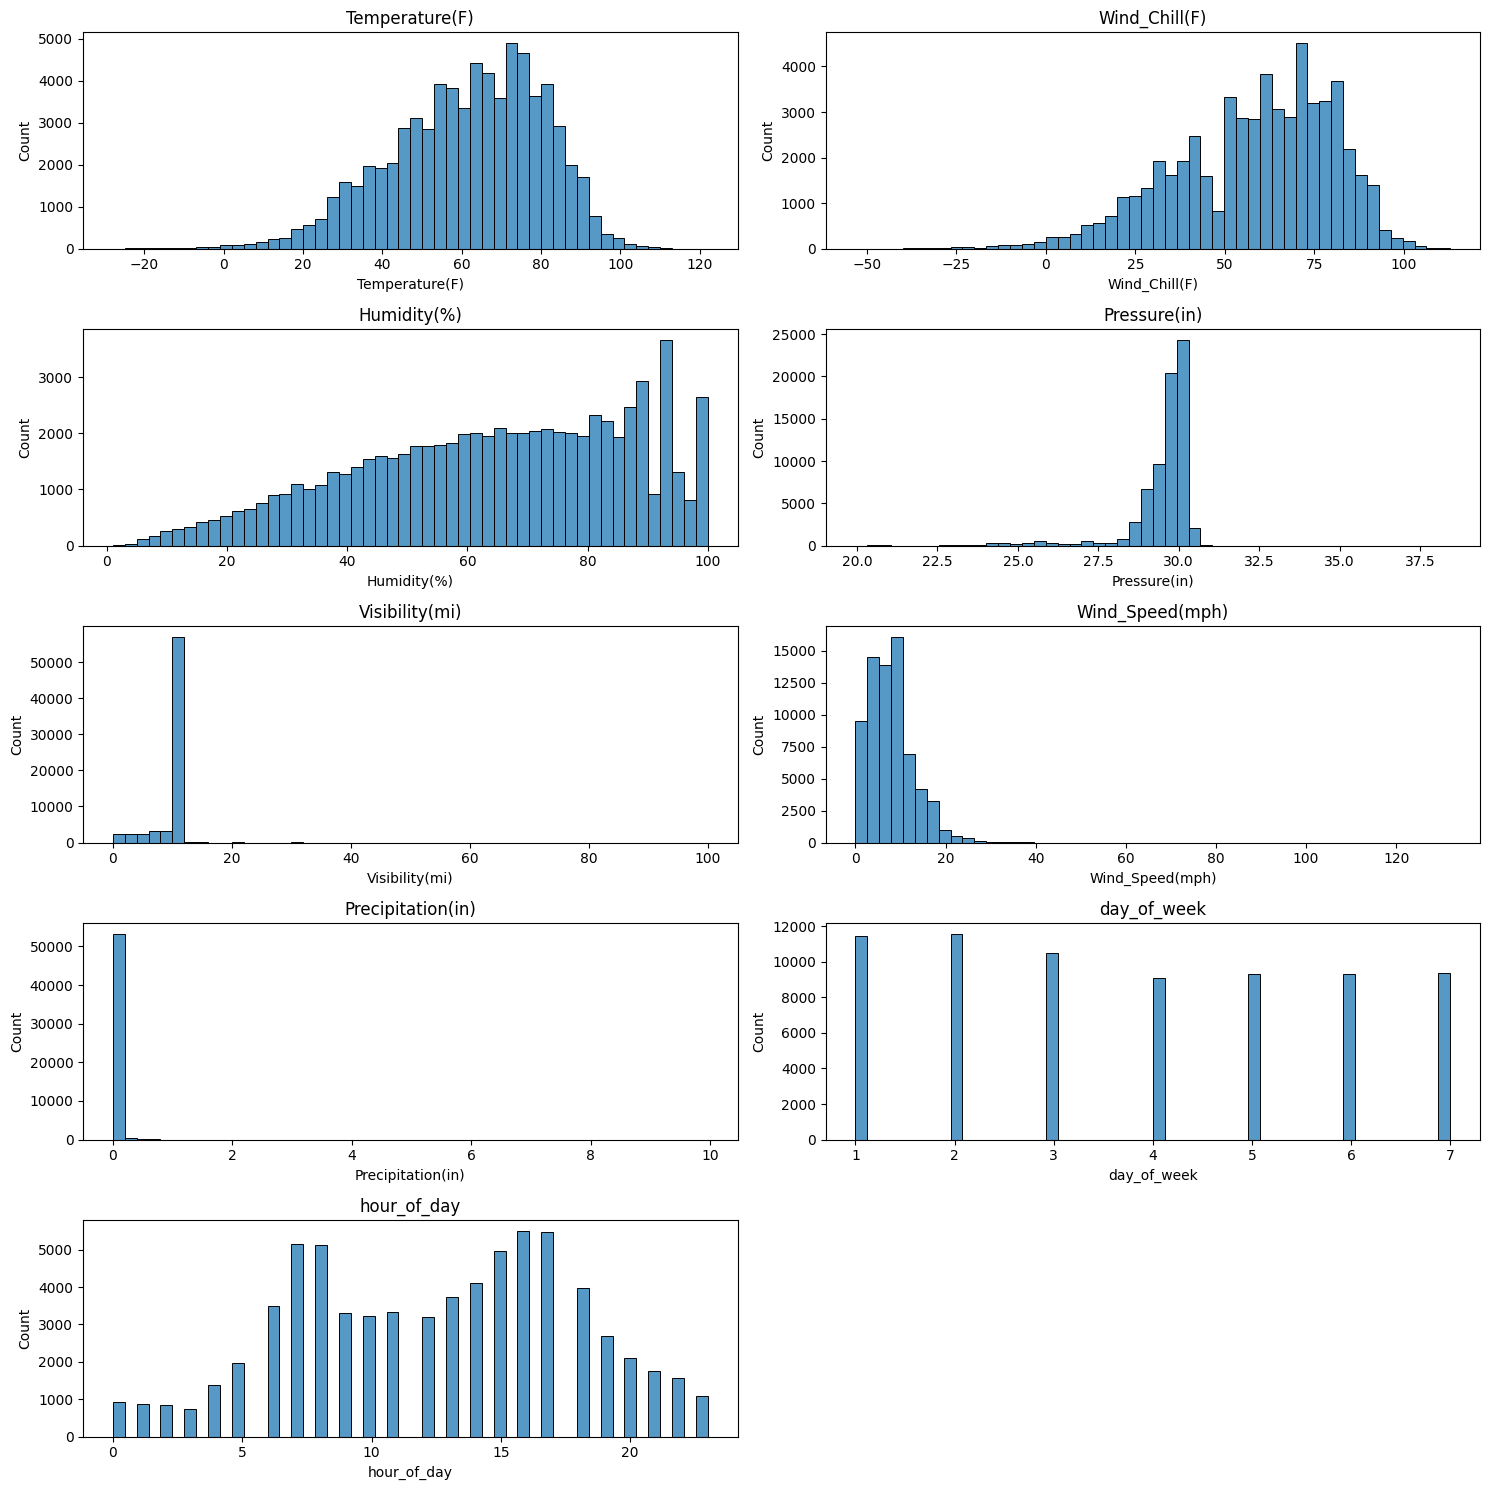

In [15]:
columns_features = ['Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)', 'day_of_week', 'hour_of_day']

plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 5, n_cols = 2, plot = sns.histplot, plot_kwargs={'bins':50}, loop_feature = 'x' ,label=False)

#### Variáveis Categóricas

Insights:

1) Variável *turning_loop* não possui informação
2) Em todas as variáveis, a condição False predomina, e a análise bivariada é necessária para entender se são relevantes

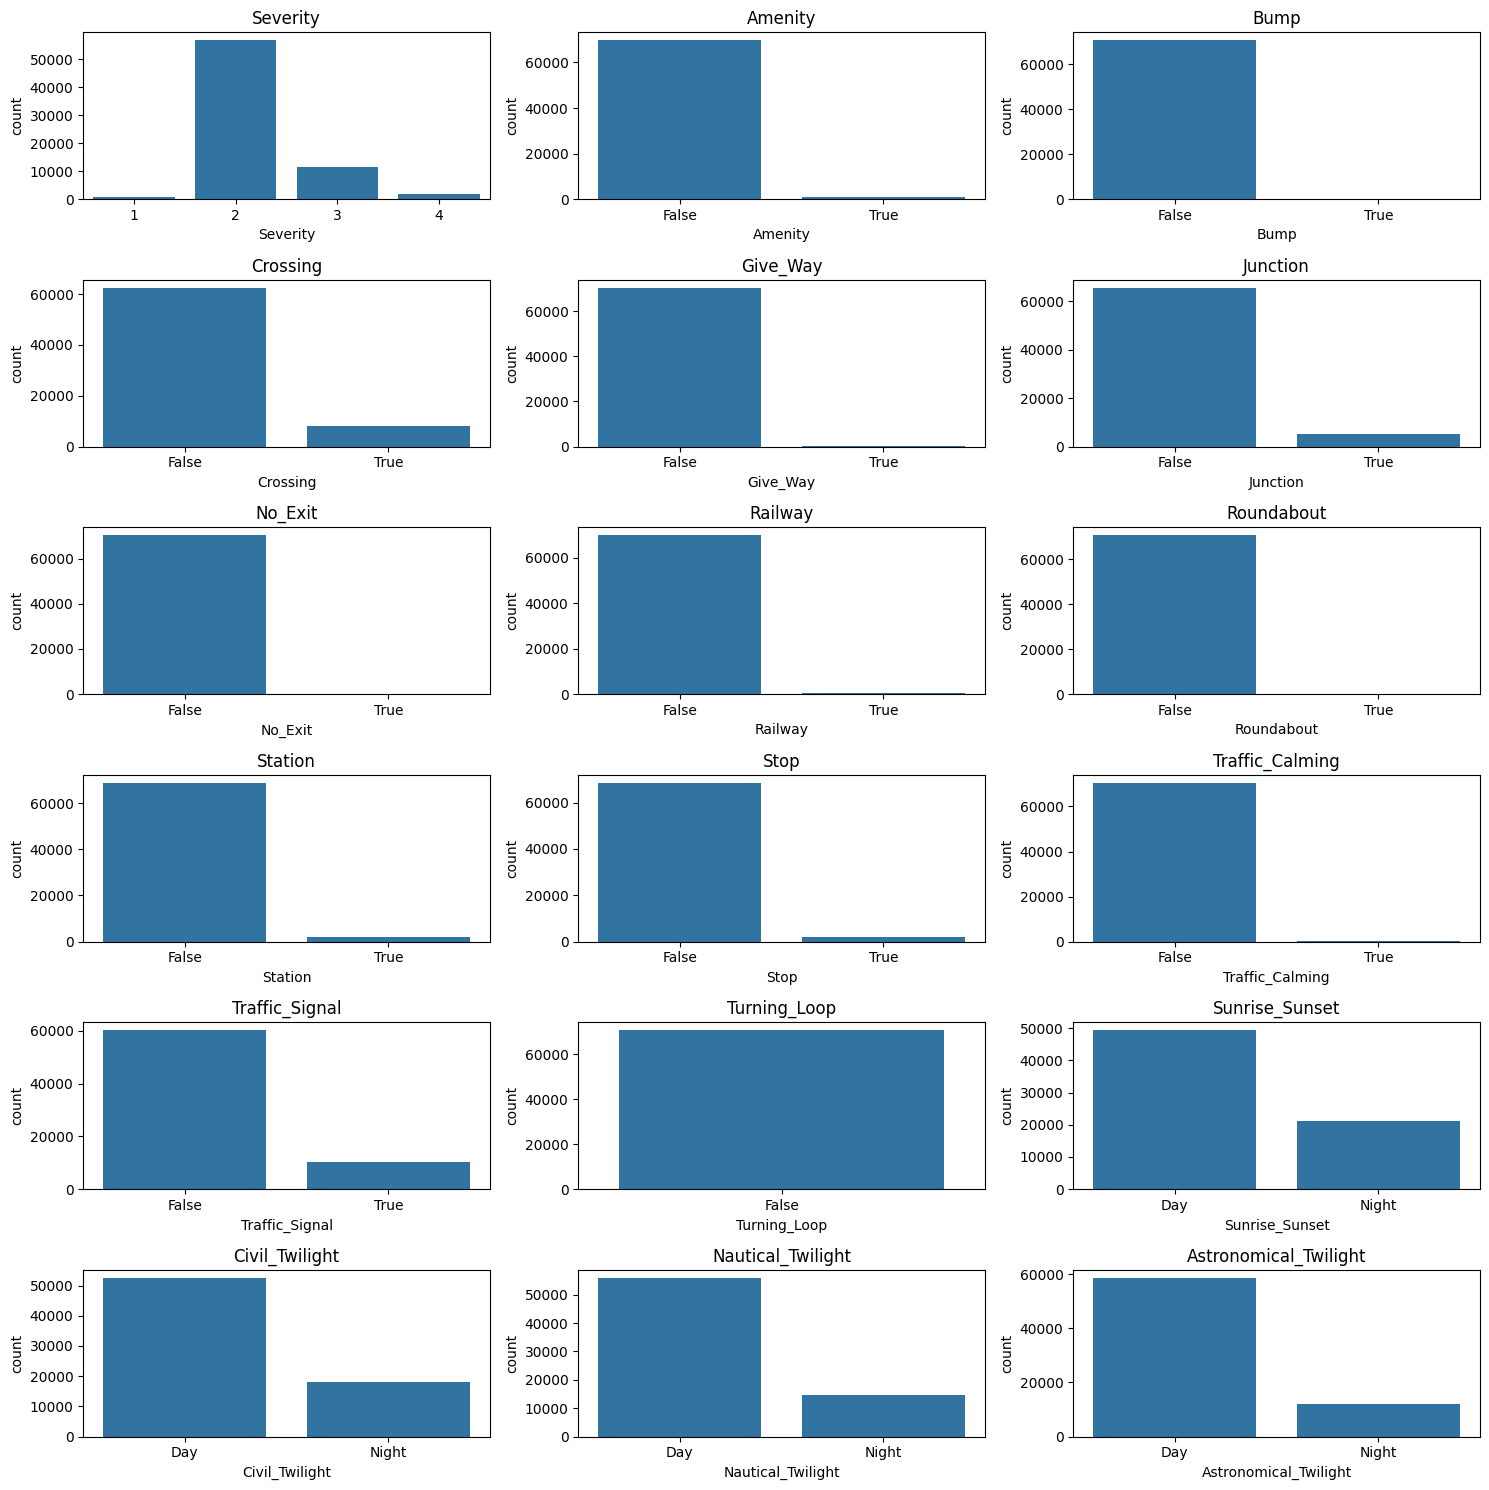

In [72]:
columns_features = ['Severity', 'Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station', 'Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']

plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 6, n_cols = 3, plot = sns.countplot, loop_feature = 'x' ,label=False)

### Análise Bivariada

#### Variáveis Numéricas

Insights:
1) Acidentes em temperaturas mais baixas tendem à ter uma gravidade maior
2) 

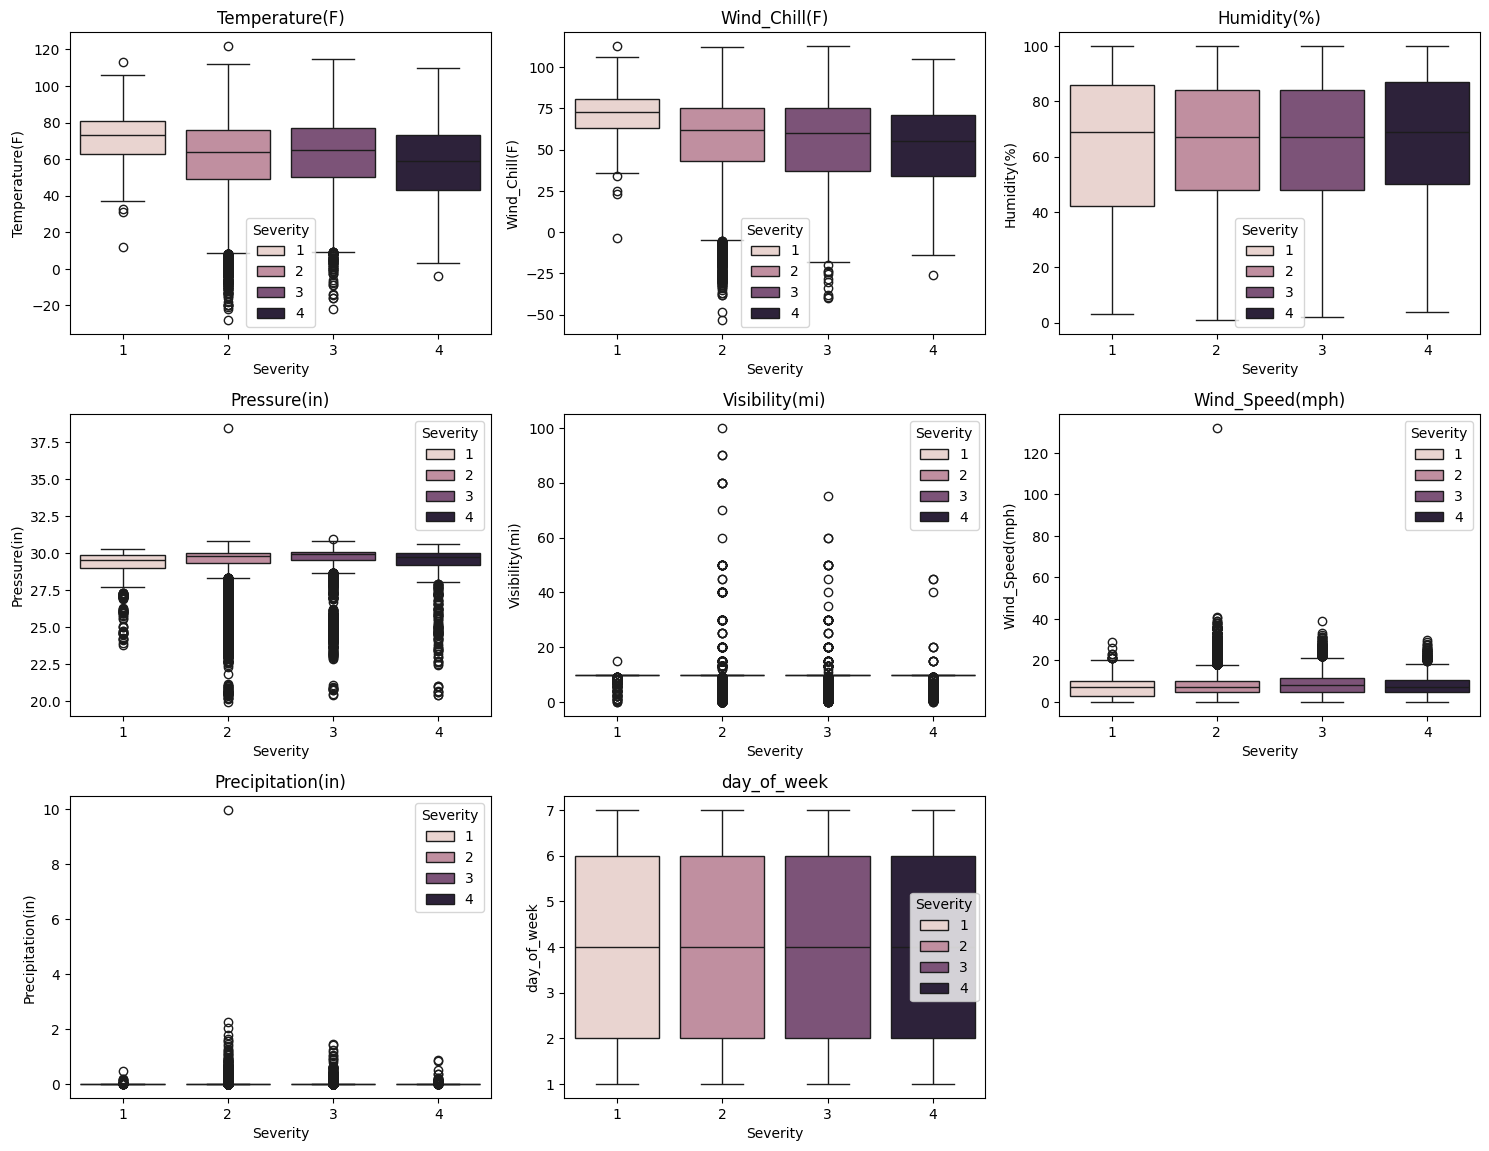

In [17]:
columns_features = ['Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']

plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 4, n_cols = 3, plot = sns.boxplot, plot_kwargs={'x': 'Severity', 'hue':'Severity'}, loop_feature = 'y' ,label=False)

#### Variáveis Categoricas

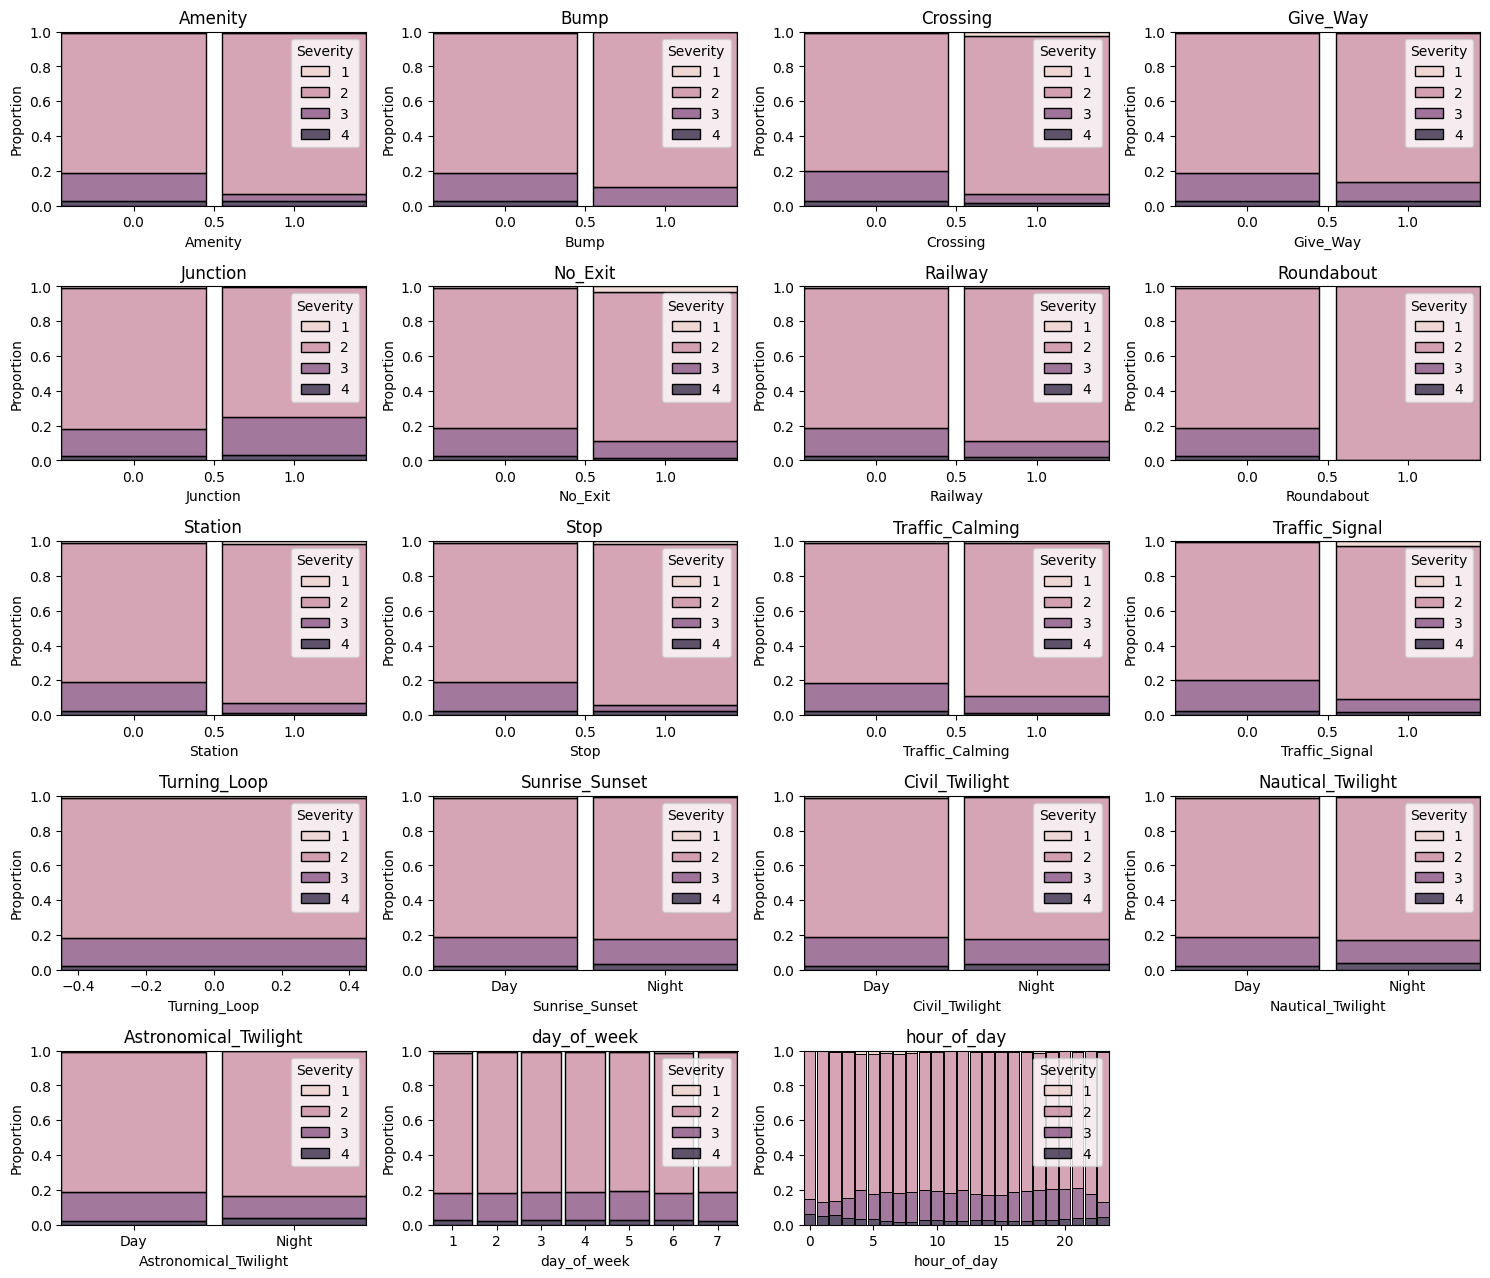

In [20]:
columns_features = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station', 'Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight', 'day_of_week','hour_of_day']

plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 6, n_cols = 4, plot = sns.histplot, plot_kwargs={'hue':'Severity', 'multiple':'fill','stat':'proportion', 'discrete':True, 'shrink':0.9}, loop_feature = 'x' ,label=False)

## **Seleção de Features**

In [28]:
selected_features = [
#  'ID',
#  'Severity',
 'Temperature(F)',
#  'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
#  'Wind_Direction', 
 'Wind_Speed(mph)',
#  'Precipitation(in)',
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop',
 'Sunrise_Sunset',
 'Civil_Twilight',
 'Nautical_Twilight',
 'Astronomical_Twilight',
 'day_of_week',
 'hour_of_day'
 ]

## **Separação do Treino e Teste**

In [29]:
# Define as proporções para treino e teste
train_ratio = 0.7
test_ratio = 0.3

# Divide o dataset em treino e teste
train_data, test_data = df_cleaned_subset.randomSplit([train_ratio, test_ratio], seed=42)

In [30]:
print(f"Treino: Número de Linhas: {train_data.count()}")
print(f"Treino: Número de Colunas: {len(train_data.columns)}")

print(f"\nTeste: Número de Linhas: {test_data.count()}")
print(f"Teste: Número de Colunas: {len(test_data.columns)}")

Treino: Número de Linhas: 4936373
Treino: Número de Colunas: 48



Teste: Número de Linhas: 2115183
Teste: Número de Colunas: 48


## **Preparação dos Dados**
- Transformar as categorias 
- Padronizar, normalizar e etc

### **Treino**

#### **_*Standarization*_**

#### **_*Normalization*_**

#### **_*Encoding*_**

- Transformar variáveis categóricas/booleanas em numéricas

##### Boolenas

In [31]:
bool_columns_to_transform = [ 
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop'
]

for column in bool_columns_to_transform:
    train_data = train_data.withColumn(
      column, col(column).cast("int")
    )

##### Categóricas

In [32]:
cat_columns_to_transform = [
'Sunrise_Sunset',
'Civil_Twilight',
'Nautical_Twilight',
'Astronomical_Twilight'
]

for column in cat_columns_to_transform:

    train_data = train_data.withColumn(
        column, when(col(column) == 'Day', 1).otherwise(0)
    )

In [33]:
train_data.select(*selected_features).show()

+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|day_of_week|hour_of_day|
+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|          37.4|      100.0|       29.62|           3.0|            4.6|      0|   0|       0|       0|       0|      0|      0

### **Teste**

#### **_*Standarization*_**

#### **_*Normalization*_**

#### **_*Encoding*_**

##### Booleadas

In [34]:
bool_columns_to_transform = [ 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop']

for column in bool_columns_to_transform:
    test_data = test_data.withColumn(
      column, col(column).cast("int")
    )

##### *Categóricas*

In [35]:
cat_columns_to_transform = [
'Sunrise_Sunset',
'Civil_Twilight',
'Nautical_Twilight',
'Astronomical_Twilight'
]

for column in cat_columns_to_transform:

    test_data = test_data.withColumn(
        column, when(col(column) == 'Day', 1).otherwise(0)
    )

In [36]:
test_data.select(*selected_features).show()

+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|day_of_week|hour_of_day|
+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|          77.0|       34.0|       30.02|          10.0|            3.5|      0|   0|       0|       0|       0|      0|      0

## **Teste e Avaliação de Modelos**

- SVM
- KNN
- Random Forest 

In [38]:
# salvar resultados
df_results = pd.DataFrame()

# Pré-processamento
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
label_indexer = StringIndexer(inputCol="Severity", outputCol="indexedLabel")

# Avaliador
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

# definindo modelo
model_name = "Random Forest"
model = RandomForestClassifier(featuresCol="features", labelCol="indexedLabel")

# Criando pipeline
pipeline = Pipeline(stages=[assembler, label_indexer, model])

# Treinamento
model_pipeline = pipeline.fit(train_data)

# Teste
predictions = model_pipeline.transform(test_data)

# # Avaliação
accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

df_results_aux = pd.DataFrame(
    {
        'Model Name': model_name,
        'Accuracy':accuracy,
        'Precision':precision,
        'Recall':recall,
        'F1-Score':f1,
     },
     index=[0]
)

df_results = pd.concat([df_results, df_results_aux], axis = 0 )

df_results



Treinando Random Forest...


25/01/26 16:29:35 WARN MemoryStore: Not enough space to cache rdd_119_8 in memory! (computed 28.8 MiB so far)
25/01/26 16:29:35 WARN MemoryStore: Not enough space to cache rdd_119_9 in memory! (computed 19.2 MiB so far)
25/01/26 16:29:35 WARN MemoryStore: Not enough space to cache rdd_119_11 in memory! (computed 28.8 MiB so far)
25/01/26 16:29:35 WARN MemoryStore: Not enough space to cache rdd_119_15 in memory! (computed 12.1 MiB so far)
25/01/26 16:29:35 WARN BlockManager: Persisting block rdd_119_11 to disk instead.
25/01/26 16:29:35 WARN BlockManager: Persisting block rdd_119_8 to disk instead.
25/01/26 16:29:35 WARN BlockManager: Persisting block rdd_119_9 to disk instead.
25/01/26 16:29:35 WARN BlockManager: Persisting block rdd_119_15 to disk instead.
25/01/26 16:29:36 WARN MemoryStore: Not enough space to cache rdd_119_12 in memory! (computed 43.2 MiB so far)
25/01/26 16:29:36 WARN BlockManager: Persisting block rdd_119_12 to disk instead.
25/01/26 16:29:36 WARN MemoryStore: Not

IllegalArgumentException: MulticlassClassificationEvaluator_5fc9cef056eb parameter metricName given invalid value precision.

In [39]:
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")


# # Avaliação
accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

df_results_aux = pd.DataFrame(
    {
        'Model Name': model_name,
        'Accuracy':accuracy,
        'Precision':precision,
        'Recall':recall,
        'F1-Score':f1,
     },
     index=[0]
)

df_results_aux

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.804417,0.647087,0.804417,0.717226


# **Abordagem: Amostragem de 5000 linhas**

In [49]:
fraction = 5000 / df.count()

# Amostra aleatória
sampled_df = df_cleaned_subset.sample(withReplacement=False, fraction=fraction, seed=42)

### **Separação do Treino e Teste**

In [50]:
# Define as proporções para treino e teste
train_ratio = 0.7
test_ratio = 0.3

# Divide o dataset em treino e teste
train_data_sampled, test_data_sampled = sampled_df.randomSplit([train_ratio, test_ratio], seed=42)

In [58]:
print(f"Treino: Número de Linhas: {train_data_sampled.count()}")
print(f"Treino: Número de Colunas: {len(train_data_sampled.columns)}")

print(f"\nTeste: Número de Linhas: {test_data_sampled.count()}")
print(f"Teste: Número de Colunas: {len(test_data_sampled.columns)}")

Treino: Número de Linhas: 3182
Treino: Número de Colunas: 48



Teste: Número de Linhas: 1397
Teste: Número de Colunas: 48


### **Preparação de Dados**

#### **Treino**

##### **_*Standarization*_**

##### **_*Normalization*_**

##### **_*Encoding*_**

- Transformar variáveis categóricas/booleanas em numéricas

In [59]:
bool_columns_to_transform = [ 
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop'
]

for column in bool_columns_to_transform:
    train_data_sampled = train_data_sampled.withColumn(
      column, col(column).cast("int")
    )

In [60]:
cat_columns_to_transform = [
'Sunrise_Sunset',
'Civil_Twilight',
'Nautical_Twilight',
'Astronomical_Twilight'
]

for column in cat_columns_to_transform:

    train_data_sampled = train_data_sampled.withColumn(
        column, when(col(column) == 'Day', 1).otherwise(0)
    )

In [61]:
train_data_sampled.select(*selected_features).show()

+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|day_of_week|hour_of_day|
+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|          57.9|       81.0|       30.01|          10.0|            6.9|      0|   0|       0|       0|       0|      0|      0

### **Teste**

#### **_*Standarization*_**

#### **_*Normalization*_**

#### **_*Encoding*_**

In [62]:
bool_columns_to_transform = [ 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop']

for column in bool_columns_to_transform:
    test_data_sampled = test_data_sampled.withColumn(
      column, col(column).cast("int")
    )

In [63]:
cat_columns_to_transform = [
'Sunrise_Sunset',
'Civil_Twilight',
'Nautical_Twilight',
'Astronomical_Twilight'
]

for column in cat_columns_to_transform:

    test_data_sampled = test_data_sampled.withColumn(
        column, when(col(column) == 'Day', 1).otherwise(0)
    )

In [64]:
test_data_sampled.select(*selected_features).show()

+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|day_of_week|hour_of_day|
+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|          41.0|      100.0|       30.13|           0.2|           11.5|      0|   0|       0|       0|       1|      0|      0

## **Teste e Avaliação de Modelos**

- SVM
- KNN
- Random Forest 

In [66]:
# salvar resultados
df_results_sampled = pd.DataFrame()

# Pré-processamento
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
label_indexer = StringIndexer(inputCol="Severity", outputCol="indexedLabel")

# Avaliador
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

# definindo modelo
model_name = "Random Forest"
model = RandomForestClassifier(featuresCol="features", labelCol="indexedLabel")

# Criando pipeline
pipeline = Pipeline(stages=[assembler, label_indexer, model])

# Treinamento
model_pipeline = pipeline.fit(train_data_sampled)

# Teste
predictions_sampled = model_pipeline.transform(test_data_sampled)

# # Avaliação
accuracy = evaluator_accuracy.evaluate(predictions_sampled)
precision = evaluator_precision.evaluate(predictions_sampled)
recall = evaluator_recall.evaluate(predictions_sampled)
f1 = evaluator_f1.evaluate(predictions_sampled)

df_results_sampled_aux = pd.DataFrame(
    {
        'Model Name': model_name,
        'Accuracy':accuracy,
        'Precision':precision,
        'Recall':recall,
        'F1-Score':f1,
     },
     index=[0]
)

df_results_sampled = pd.concat([df_results_sampled, df_results_sampled_aux], axis = 0 )

df_results_sampled


,Model Name,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.816034,0.665912,0.816034,0.733369


## Comparando as diferentes abordagens

In [ ]:
# dataset completo
df_results

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.804417,0.647087,0.804417,0.717226


In [67]:
# amostra de 5000 linhas
df_results_sampled

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.816034,0.665912,0.816034,0.733369
